In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SignalClassifier(nn.Module):
    def __init__(self, input_channels, filter_size, win_len):
        super(SignalClassifier, self).__init__()

        # Initial convolution layer with increased filters
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=2, kernel_size=filter_size, padding='same')
        self.bn1 = nn.BatchNorm1d(2)  # BatchNorm layer after the first conv layer
        self.prelu1 = nn.PReLU()

        # Branch 1: Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList()
        self.branch1_bns = nn.ModuleList()  # BatchNorm layers for branch 1
        for i in range(2):
            self.branch1_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch1_bns.append(nn.BatchNorm1d(8))
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch1 = nn.Linear(8*win_len, 128)
        self.fc2_branch1 = nn.Linear(128, 1)
        
        # Branch 2: Convolution layers followed by output layer
        self.branch2_layers = nn.ModuleList()
        self.branch2_bns = nn.ModuleList()  # BatchNorm layers for branch 2
        for i in range(2):
            self.branch2_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch2_bns.append(nn.BatchNorm1d(8))
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch2 = nn.Linear(8*win_len, 128)
        self.fc2_branch2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.prelu1(self.bn1(self.conv1(x)))  # Apply BatchNorm after the first conv layer

        # Branch 1
        x_branch1 = x
        for layer, bn, prelu in zip(self.branch1_layers, self.branch1_bns, self.branch1_prelus):
            x_branch1 = prelu(bn(layer(x_branch1)))  # Apply BatchNorm after each conv layer
        x_branch1 = self.out_branch1(x_branch1)
        x_branch1 = x_branch1.view(x_branch1.size(0), -1)  # Flatten the output
        x_branch1 = F.relu(self.fc1_branch1(x_branch1))
        out1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = x
        for layer, bn, prelu in zip(self.branch2_layers, self.branch2_bns, self.branch2_prelus):
            x_branch2 = prelu(bn(layer(x_branch2)))  # Apply BatchNorm after each conv layer
        x_branch2 = self.out_branch2(x_branch2)
        x_branch2 = x_branch2.view(x_branch2.size(0), -1)  # Flatten the output
        x_branch2 = F.relu(self.fc1_branch2(x_branch2))
        out2 = self.fc2_branch2(x_branch2)

        return out1, out2


In [2]:
# Load the data
train_database = torch.load('./Data/train_classification')
test_database = torch.load('./Data/test_classification')


In [3]:
train_database.keys()

dict_keys(['seq_tensor', 'sim_tensor', 'file_names', 'mode_descriptions'])

In [4]:
train_names = train_database['file_names']
test_names = test_database['file_names']

train_modes = train_database['mode_descriptions']
test_modes = test_database['mode_descriptions']

In [5]:
test_modes[0]

('Conduction2', 'Conduction2')

In [6]:
def mode_to_int(mode):
    return 0 if 'Conduction' in mode else 1

test_modes_int = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in test_modes]
train_modes_int = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in train_modes]


In [7]:
train_data = train_database['sim_tensor']
test_data = test_database['sim_tensor']

In [8]:
train_data.shape, test_data.shape

(torch.Size([140, 3, 378986]), torch.Size([60, 3, 378986]))

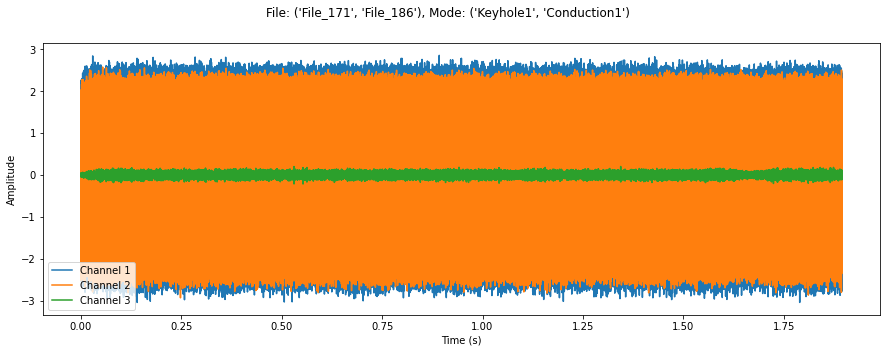

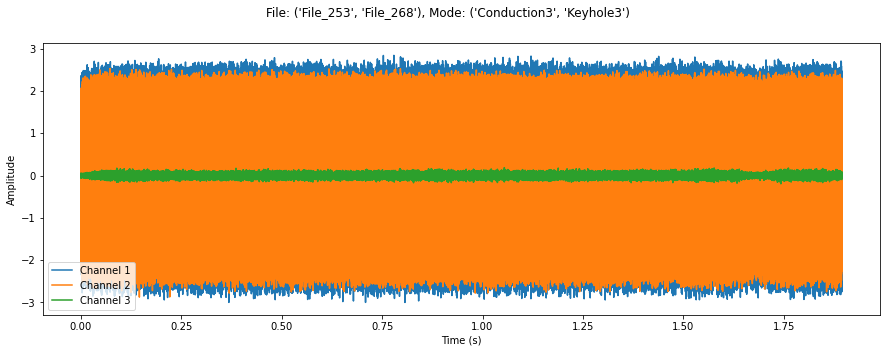

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Select 2 random indexes from the training data
random_indexes = np.random.choice(train_data.size(0), 2, replace=False)

# Sampling frequency
Fs = 200000  # 200kHz

# Plot the selected files including file name and mode description
for idx in random_indexes:
    sim_signal = train_data[idx]  # Extract the sim_tensor for the selected index
    time_vector = np.linspace(0, sim_signal.size(1) / Fs, sim_signal.size(1), endpoint=False)  # Time vector
    file_name = train_names[idx]  # Extract file name
    mode_description = train_modes[idx]  # Extract mode description

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"File: {file_name}, Mode: {mode_description}")

    # Plot each channel
    for i in range(sim_signal.size(0)):  
        plt.plot(time_vector, sim_signal[i].numpy(), label=f"Channel {i+1}")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, modes, names):
        """
        Args:
            data (Tensor): A tensor containing the data.
            modes (list): A list of mode descriptions for each sample.
            names (list): A list of file names for each sample.
        """
        self.data = data
        self.modes = modes
        self.names = names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mode = self.modes[idx]
        name = self.names[idx]
        return sample, mode, name


In [11]:
# Create dataset instances
train_dataset = CustomDataset(train_data, train_modes_int, train_names)
test_dataset = CustomDataset(test_data, test_modes_int, test_names)

# Create DataLoader instances
batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
input_channels = 3  
filter_size = 501  
win_len = train_data.shape[-1]  

model = SignalClassifier(input_channels=input_channels, filter_size=filter_size, win_len=win_len)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
# Define the loss function
loss_function = nn.BCEWithLogitsLoss()


In [15]:
model.to(device)

SignalClassifier(
  (conv1): Conv1d(3, 2, kernel_size=(501,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(501,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(501,), stride=(1,), padding=same)
  )
  (branch1_bns): ModuleList(
    (0-1): 2 x BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch1_prelus): ModuleList(
    (0-1): 2 x PReLU(num_parameters=1)
  )
  (out_branch1): Conv1d(8, 8, kernel_size=(501,), stride=(1,), padding=same)
  (fc1_branch1): Linear(in_features=3031888, out_features=128, bias=True)
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (branch2_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(501,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(501,), stride=(1,), padding=same)
  )
  (branch2_bns): M

In [16]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [17]:
def train(model, device, train_loader, optimizer, loss_function):
    model.train()
    total_loss = 0
    for batch_idx, (data, (target1, target2), _) in enumerate(train_loader):  
        data = data.to(device)
        target1, target2 = target1.to(device).float(), target2.to(device).float()  
        
        optimizer.zero_grad()
        
        output1, output2 = model(data)  
        
        # Compute loss separately for each output
        loss1 = loss_function(output1.squeeze(), target1)
        loss2 = loss_function(output2.squeeze(), target2)
        
        # Sum the losses
        combined_loss = loss1 + loss2
        
        combined_loss.backward()  # Backpropagate the total loss
        optimizer.step()
        
        # Update running total_loss
        total_loss += combined_loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Training loss: {avg_loss:.4f}')


In [18]:
def evaluate(model, device, test_loader, loss_function):
    model.eval()
    total_loss = 0
    correct1, correct2 = 0, 0  # To track correct predictions for both outputs
    with torch.no_grad():
        for data, (target1, target2), _ in test_loader:
            data = data.to(device)
            target1, target2 = target1.to(device).float(), target2.to(device).float()
            
            output1, output2 = model(data)
            
            # Calculate loss for each output
            loss1 = loss_function(output1.squeeze(), target1)
            loss2 = loss_function(output2.squeeze(), target2)
            total_loss += (loss1 + loss2).item()
            
            # Manually apply sigmoid to model outputs for accuracy calculation
            sig_output1 = torch.sigmoid(output1).squeeze()
            sig_output2 = torch.sigmoid(output2).squeeze()

            # Thresholding predictions at 0.5 to obtain binary predictions
            pred1 = sig_output1 > 0.5
            pred2 = sig_output2 > 0.5

            # Update correct counts
            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(target2.view_as(pred2)).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    total_correct = correct1 + correct2  # Total correct predictions
    total_items = (len(test_loader.dataset) * target1.size(0) * 2)  # Adjust for the actual number of items, corrected for batch size
    accuracy = total_correct / total_items
    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {total_correct}/{total_items} ({100. * accuracy:.2f}%)')


In [19]:
epochs = 1000  # Define the number of epochs

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Training phase
    train(model, device, train_loader, optimizer, loss_function)
    
    if epoch%10 == 0:
        # Evaluation phase
        evaluate(model, device, test_loader, loss_function)


Epoch 1/1000
Training loss: 5.8145
Test set: Average loss: 2.1997, Accuracy: 62/7200 (0.86%)
Epoch 2/1000
Training loss: 1.6484
Epoch 3/1000
Training loss: 35.8107
Epoch 4/1000
Training loss: 6.7637
Epoch 5/1000
Training loss: 1.9121
Epoch 6/1000
Training loss: 0.0162
Epoch 7/1000
Training loss: 0.0287
Epoch 8/1000
Training loss: 0.0088
Epoch 9/1000
Training loss: 0.0010
Epoch 10/1000
Training loss: 0.0006
Epoch 11/1000
Training loss: 0.0026
Test set: Average loss: 4.4172, Accuracy: 60/7200 (0.83%)
Epoch 12/1000
Training loss: 0.0001
Epoch 13/1000
Training loss: 0.0001
Epoch 14/1000
Training loss: 0.0009
Epoch 15/1000
Training loss: 0.0002
Epoch 16/1000
Training loss: 0.0001
Epoch 17/1000
Training loss: 0.0000
Epoch 18/1000
Training loss: 0.0001
Epoch 19/1000
Training loss: 0.0001
Epoch 20/1000
Training loss: 0.0001
Epoch 21/1000
Training loss: 0.0002
Test set: Average loss: 3.8958, Accuracy: 58/7200 (0.81%)
Epoch 22/1000
Training loss: 0.0002
Epoch 23/1000
Training loss: 0.0001
Epoch 

KeyboardInterrupt: 